# Analysis of the Ground State of a NSM Hamiltonian

We want to understand if the Quasiparticle decomposition [CITE HERE PAPERS] of the NSM Hamiltonian can be easily implemented. In order to do that, we want to look at the component of a ground state of a Nucleus using the NSM representation. In this case, since the configuration space is small, we are going to study a p-shell Nucleus.

#### Imports

In [1]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverter
file_name='data/cki'
qq_filename='data/qq.p'
pp_filename='data/pair_inter.p'
SPS=SingleParticleState(file_name=file_name)

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Hyperparameters

In [ ]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'


In [3]:
matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)
matrix_pp,_=get_twobody_nuclearshell_model(file_name=pp_filename)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.92it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  9.62it/s]


#### Set up of the Quantum Objects and computation of the ground state

In [72]:


# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))




size= 24 12
[-23.93429271]
total_m= [0.]


(ONLY WITH THE P SHELL REPRESENTATION) Computation of the restricted basis Hamiltonian from the interaction

In [5]:
interaction_qq={}
interaction_qr={}
interaction_rq={}
interaction_rr={}

for a,state_a in enumerate(SPS.state_encoding):
    for b,state_b in enumerate(SPS.state_encoding):
        for c,state_c in enumerate(SPS.state_encoding):
            for d,state_d in enumerate(SPS.state_encoding):
                
                na,la,ja,ma,ta,tza=state_a
                nb,lb,jb,mb,tb,tzb=state_b
                nc,lc,jc,mc,tc,tzc=state_c
                nd,ld,jd,md,td,tzd=state_d
                
                a_tilde=SPS.get_index((na,la,ja,-ma,ta,tza))
                b_tilde=SPS.get_index((nb,lb,jb,-mb,tb,tzb))
                c_tilde=SPS.get_index((nc,lc,jc,-mc,tc,tzc))
                d_tilde=SPS.get_index((nd,ld,jd,-md,td,tzd))

                
                if ma==-mb and mc==-md and ja==jb and jc==jd:

                    if (a,b,c,d) in twobody_matrix.keys():

                        interaction_qq[a,b,c,d]=twobody_matrix[a,b,c,d]
                
                # elif (a_tilde,b_tilde,c_tilde,d_tilde) in twobody_matrix.keys() and (a,b,c,d) in twobody_matrix.keys():
                #     interaction_qq[a,b,c,d]=twobody_matrix[a,b,c,d]
                
                
                else:
                    if (a,b,c,d) in twobody_matrix.keys():
                        interaction_rr[a,b,c,d]=twobody_matrix[a,b,c,d]
                
                
                
print(interaction_qq)
print(twobody_matrix)



{(0, 3, 0, 3): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (0, 3, 3, 0): 1.6921, (0, 3, 4, 5): -3.763858685577873, (0, 3, 5, 4): 3.763858685577873, (0, 9, 0, 9): -2.5928549999999992, (0, 9, 1, 8): -0.009165000000000534, (0, 9, 2, 7): -1.0522650000000002, (0, 9, 3, 6): -0.9007550000000002, (0, 9, 4, 11): -1.3652289845057242, (0, 9, 5, 10): 2.3986297010721485, (0, 9, 6, 3): 0.9007550000000002, (0, 9, 7, 2): 1.0522650000000002, (0, 9, 8, 1): 0.009165000000000534, (0, 9, 9, 0): 2.5928549999999992, (0, 9, 10, 5): -2.3986297010721485, (0, 9, 11, 4): 1.3652289845057242, (1, 2, 0, 3): 1.0430999999999995, (1, 2, 1, 2): -1.6921, (1, 2, 2, 1): 1.6921, (1, 2, 3, 0): -1.0430999999999995, (1, 2, 4, 5): 3.763858685577873, (1, 2, 5, 4): -3.763858685577873, (1, 8, 0, 9): -0.009165000000000534, (1, 8, 1, 8): -4.008095000000001, (1, 8, 2, 7): -2.315995000000001, (1, 8, 3, 6): -1.052265, (1, 8, 4, 11): 1.7096958900278656, (1, 8, 5, 10): -2.054162795550007, (1, 8, 6, 3): 1

Create the Pairing Hamiltonian

In [62]:

PPoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
PPoperator.get_twobody_interaction(twobody_dict=matrix_pp)
PPoperator.get_hamiltonian()

MeanFieldHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
MeanFieldHamiltonian.get_external_potential(SPS.energies)
MeanFieldHamiltonian.get_hamiltonian()

Hamiltonian_pairing=PPoperator.hamiltonian+MeanFieldHamiltonian.hamiltonian
value,_=eigsh(Hamiltonian_pairing,k=1)
print(value)
print('deformation=',psi0.transpose().conjugate().dot(PPoperator.hamiltonian.dot(psi0)))

216it [00:00, 703.60it/s]


[8.27441025]
deformation= [[-2.46467226]]


Create the QQ Hamiltonian and the RR Hamiltonian from the interaction

In [74]:


# compute the NSM Hamiltonian
QQHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
QQHamiltonian.get_external_potential(external_potential=SPS.energies)

QQHamiltonian.get_twobody_interaction(twobody_dict=interaction_qq)

QQHamiltonian.get_hamiltonian()

egs,psi0=QQHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=QQHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))

# RQHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# print('size=',size_a+size_b,size_b)
# RQHamiltonian.get_external_potential(external_potential=SPS.energies)

# RQHamiltonian.get_twobody_interaction(twobody_dict=interaction_rq)

# RQHamiltonian.get_hamiltonian()

# egs,psi0=RQHamiltonian.get_spectrum(n_states=1)

# print(egs)

# QRHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# print('size=',size_a+size_b,size_b)
# QRHamiltonian.get_external_potential(external_potential=SPS.energies)

# QRHamiltonian.get_twobody_interaction(twobody_dict=interaction_qr)

# QRHamiltonian.get_hamiltonian()

# egs,psi0=QRHamiltonian.get_spectrum(n_states=1)

# print(egs)


print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=QQHamiltonian.basis))


plt.bar(np.arange(psi0.shape[0]),psi0[:,0].conjugate()*psi0[:,0])
plt.show()


# compute the NSM Hamiltonian
RRHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
RRHamiltonian.get_external_potential(external_potential=SPS.energies)

RRHamiltonian.get_twobody_interaction(twobody_dict=interaction_rr)

RRHamiltonian.get_hamiltonian()

egs,psi0=RRHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=RRHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))

plt.bar(np.arange(psi0.shape[0]),psi0[:,0].conjugate()*psi0[:,0])
plt.show()

size= 24 12


NameError: name 'interaction_qq' is not defined

#### Analysis of the component of the Ground state

pr 8^Be= 0.03346097923987017 0.0196078431372549 



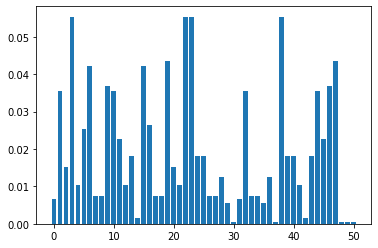

(51,)
(51, 1)
[[-26.18735105]]
(51, 1)
[[-5.38707576]]


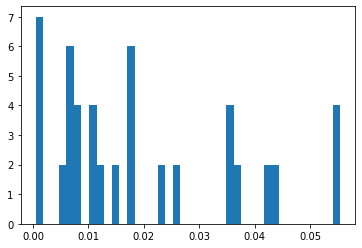

0.9941174421486227
(51, 1)
[[1 1 0 0 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 1 0 1]
 [1 0 1 0 0 0 0 1 0 1 0 0]
 [1 0 1 0 0 0 0 0 1 0 0 1]
 [1 0 1 0 0 0 0 0 0 1 1 0]
 [1 0 0 1 0 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 1 1 0 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 1]
 [1 0 0 1 0 0 0 0 1 0 1 0]
 [1 0 0 1 0 0 0 0 0 0 1 1]
 [1 0 0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 1 0 0 0 0 1 0 1]
 [1 0 0 0 0 1 0 1 0 1 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 1]
 [1 0 0 0 0 1 0 0 0 1 1 0]
 [0 1 1 0 0 0 1 0 0 1 0 0]
 [0 1 1 0 0 0 0 1 1 0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 1]
 [0 1 1 0 0 0 0 0 1 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 1 1]
 [0 1 0 1 0 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 1 0 0 0 0 1]
 [0 1 0 1 0 0 0 1 0 0 1 0]
 [0 1 0 0 1 0 0 1 0 1 0 0]
 [0 1 0 0 1 0 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 0 0 1 1 0]
 [0 1 0 0 0 1 1 0 0 1 0 0]
 [0 1 0 0 0 1 0 1 1 0 0 0]
 [0 1 0 0 0 1 0 1 0 0 0 1]
 [0 1 0 0 0 1 0 0 1 0 1 0]
 [0 1 0 0 0 1 0 0 0 0 1 1]
 [0 0 1 1 0 0 1 1 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 0 1 0]
 [0 0 1 0 1 0 1 0 0 1 0 0]
 [0 0 1 0 1 0 0 1 1 0 0 0]
 [0 0 1 0 1 0 0 1 0 0 0 1]
 

In [8]:





# we need to get the argsort for
prob=(np.conj(psi0)*psi0)[:,0]

pr=np.sum(prob**2)
print('pr 8^Be=',pr,1/prob.shape[0],'\n')

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

print(prob.shape)
idx_sort=np.argsort(-1*prob[:])

cutoff_value=0.005
cutoff_prob=prob[prob>cutoff_value]


psi_cutoff=psi0.copy()
psi_cutoff[prob<cutoff_value]=0.
psi_cutoff=psi_cutoff/np.linalg.norm(psi_cutoff)
print(psi_cutoff.shape)
print(psi_cutoff.conj().T @ NSMHamiltonian.hamiltonian @ psi_cutoff)

psi_out=psi0.copy()
psi_out[prob>=cutoff_value]=0.
psi_out=psi_out/np.linalg.norm(psi_out)
print(psi_out.shape)
print(psi_out.conj().T @ NSMHamiltonian.hamiltonian @ psi_out)



plt.hist(prob,bins=40)
plt.show()

print(np.sum(cutoff_prob))
plt.show()


from itertools import combinations

couples_nn=[[0,3],[1,2],[4,5],[6,9],[7,8],[10,11],]
couples_np=[[0,9],[3,6],[1,8],[2,7],[4,11],[5,10]]

def new_base_computation(base:np.ndarray):
    
    indices=np.nonzero(base)[0]
    pairs = list(combinations(indices, 2))
    new_base=np.zeros(basis.shape[-1])
   
    print('base=',base,'\n')     
            
    list_of_token_indices=[]
    
    for i in range(len(couples_nn)):
        
        if base[couples_nn[i][0]]+base[couples_nn[i][1]]!=2 :
            continue
        else:
            new_base[i]+=1
            base[couples_nn[i][0]]=0
            base[couples_nn[i][1]]=0
    for i in range(len(couples_np)):
        if base[couples_np[i][0]]+base[couples_np[i][1]]!=2 :
            continue
        else:
            new_base[i+len(couples_nn)]+=1
            base[couples_np[i][0]]=0
            base[couples_np[i][1]]=0
    
    print(list_of_token_indices,new_base)
    exit
    return new_base
print(psi0.shape)
prob=0.
basis=NSMHamiltonian.basis.copy()
print(basis)
for i,base in enumerate(basis[:]):
    print(base,'auuu')
    new_base=new_base_computation(base)
    print(new_base)
    if np.sum(new_base)==(nparticles_a+nparticles_b)//2:
        prob+=psi0[i,0]*np.conjugate(psi0[i,0])

    
print('prob=',prob)
    


#### Comparison of different IPR computations

Imports

In [88]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/usdb.nat'
qq_filename='data/qq.sd'
SPS=SingleParticleState(file_name=file_name)

Data loading

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/

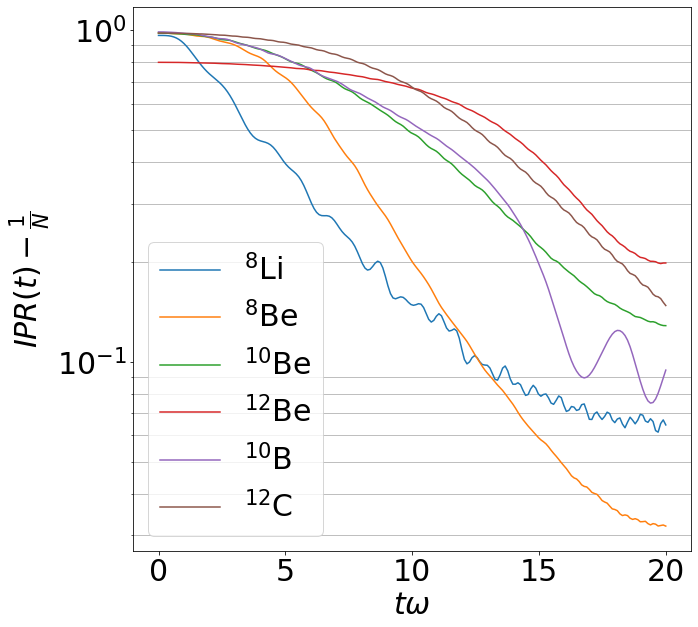

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/

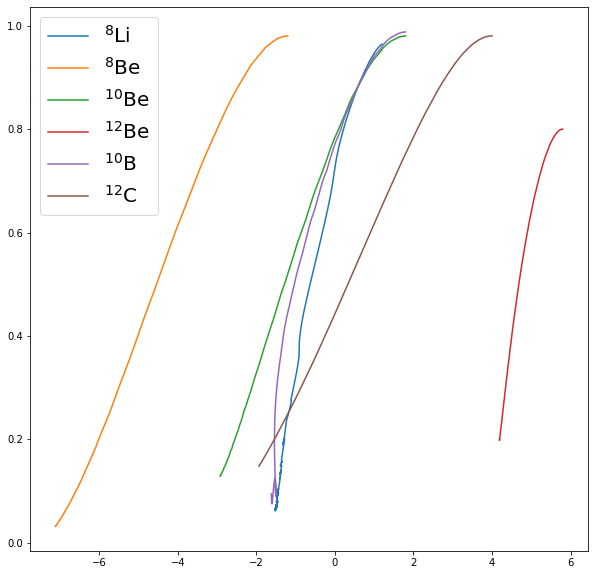

In [7]:
data=np.load('data/ipr_computation_pshell.npz')
### temporary
tf=20
time=np.linspace(0,tf,int(tf*10))
labels=data['labels']
iprs=data['ipr']
qqs=data['qq']
entanglement_pn=data['entropy_proton_neutron']
entanglement_initial=data['entropy_initial_rest']

plt.figure(figsize=(10,10))
for idx,ipr in enumerate(iprs):
    plt.plot(time,ipr,label=labels[idx])
    
plt.legend(fontsize=30)
plt.semilogy()
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$IPR(t)-\frac{1}{N}$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30)
plt.grid(True,which='minor')

plt.show()

plt.figure(figsize=(10,10))
for i in range(len(labels)):
    plt.plot(qqs[i],iprs[i],label=labels[i])
plt.legend(fontsize=20)
plt.show()


Analysis of entanglement

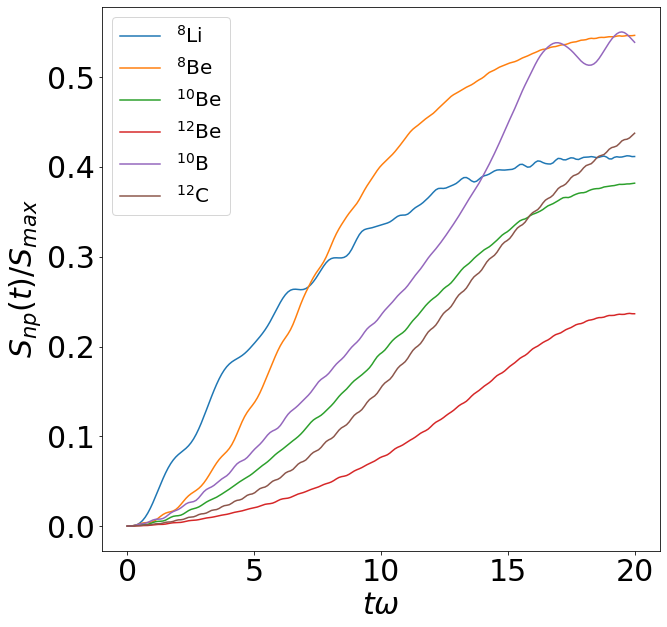

In [8]:
plt.figure(figsize=(10,10))
for i in range(len(labels)):
    
    plt.plot(time,entanglement_pn[i]/np.log(2**6),label=labels[i])
plt.legend(fontsize=20)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$S_{np}(t)/S_{max}$',fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

#### QuasiParticleMapping

In [75]:
QPC=QuasiParticlesConverter()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)

print(QPC.rest_basis.shape)
print(QPC.couples)


(15, 81)
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]
(66, 24)
[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]


In [76]:

for i,b in enumerate(QPC.quasiparticle_basis):
    
    idxs=np.nonzero(b)[0]
    print('index=',i)
    for index in idxs:
        print(QPC.couples[index])
    print('\n')

index= 0
[0, 5]
[1, 4]


index= 1
[0, 5]
[2, 3]


index= 2
[0, 5]
[6, 7]


index= 3
[0, 5]
[8, 11]


index= 4
[0, 5]
[9, 10]


index= 5
[1, 4]
[2, 3]


index= 6
[1, 4]
[6, 7]


index= 7
[1, 4]
[8, 11]


index= 8
[1, 4]
[9, 10]


index= 9
[2, 3]
[6, 7]


index= 10
[2, 3]
[8, 11]


index= 11
[2, 3]
[9, 10]


index= 12
[6, 7]
[8, 11]


index= 13
[6, 7]
[9, 10]


index= 14
[8, 11]
[9, 10]




In [77]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


values,psi=eigsh(hamiltonian_qq,k=1)
e0=values[0]

print(values[0])
values,psi=eigsh(hamiltonian_qq+(1/e0)*hamiltonian_qr @ hamiltonian_rq,k=1)

e1=values[0]

values,psi=eigsh(hamiltonian_qq+(1/e1)*hamiltonian_qr @ hamiltonian_rq+(1/e1**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq,k=1)

e2=values[0]
values,psi=eigsh(hamiltonian_qq+(1/e2)*hamiltonian_qr @ hamiltonian_rq+(1/e2**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq+(1/e2**3)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rr @ hamiltonian_rq,k=1)


print(values[0],np.abs((values[0]-egs[0])/egs[0]))

-23.42493917643891
-23.84153619377299 0.0038754650340752914


#### Reduce the Pairing Hamiltonian

In [78]:
pairing_hamiltonian_qq=QPC.particles2quasiparticles @ PPoperator.hamiltonian @ QPC.particles2quasiparticles.T

value,_=eigsh(pairing_hamiltonian_qq,k=1)
print(value)

meanfiled_hamiltonian_qq=QPC.particles2quasiparticles @ MeanFieldHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


NameError: name 'PPoperator' is not defined

#### Basis of the HQQ

In [79]:
print(hamiltonian_qq)
for i in range(hamiltonian_qq.shape[0]):
    print(i,QPC.quasiparticle_basis[i],'\n')

  (0, 0)	-20.1382
  (0, 1)	0.8598999999999998
  (0, 2)	0.900781889989654
  (0, 3)	1.1336192497488327
  (0, 4)	-1.3995613925794368
  (0, 5)	-0.4062999999999996
  (0, 6)	-0.900781889989654
  (0, 7)	-1.9314456782406446
  (0, 8)	0.6017349640876247
  (1, 0)	0.8598999999999998
  (1, 1)	-19.8547
  (1, 2)	-0.900781889989654
  (1, 3)	-0.7347060355029268
  (1, 4)	1.7984746068253425
  (1, 5)	0.6897999999999996
  (1, 9)	-0.900781889989654
  (1, 10)	-1.9314456782406446
  (1, 11)	0.6017349640876247
  (2, 0)	0.900781889989654
  (2, 1)	-0.900781889989654
  (2, 2)	-17.39346666666667
  (2, 3)	-0.7177133829043456
  (2, 4)	0.7177133829043456
  (2, 6)	0.6897999999999996
  (2, 9)	-0.4062999999999996
  :	:
  (12, 6)	1.1336192497488327
  (12, 7)	0.900781889989654
  (12, 9)	-0.7347060355029268
  (12, 10)	-0.900781889989654
  (12, 12)	-4.8668
  (12, 13)	0.9008999999999998
  (12, 14)	0.7177133829043456
  (13, 2)	0.6017349640876247
  (13, 4)	-0.900781889989654
  (13, 6)	-1.3995613925794368
  (13, 8)	0.90078188998

#### Implement the cyclic method

In [66]:


tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=50
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result
    
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    for j in range(i):
        tot_hamiltonian=tot_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(tot_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

     
      

 16%|█▌        | 8/50 [00:00<00:00, 79.24it/s]

-140.9144359906236
0.05920422236504105 index= 0
-141.58937072390248
0.054698113797923005 index= 1
-142.19666973825957
0.050643565770586436 index= 2
-142.74187981055073
0.04700354599312588 index= 3
-143.23122526862363
0.04373649859997968 index= 4
-143.6710187398264
0.040800278206162034 index= 5
-144.06726704388748
0.03815478110904069 index= 6
-144.42544877587238
0.035763430225020605 index= 7
-144.75042025397482
0.03359380301613115 index= 8
-145.04640555900323
0.03161769799001976 index= 9
-145.31703487398397
0.02981087873088395 index= 10
-145.56540609545323
0.02815266256018685 index= 11


 32%|███▏      | 16/50 [00:00<00:00, 51.69it/s]

-145.7941540221862
0.026625458607658827 index= 12
-146.0055182146032
0.025214314757341302 index= 13
-146.201405047431
0.023906503361559694 index= 14
-146.38344214910575
0.022691157783765896 index= 15
-146.55302492150264
0.021558961815985538 index= 16
-146.71135560779254
0.020501888847666697 index= 17
-146.8594757232609
0.019512985345794678 index= 18


 44%|████▍     | 22/50 [00:00<00:00, 40.56it/s]

-146.9982927712961
0.018586192489284677 index= 19
-147.1286021472442
0.017716199930918327 index= 20
-147.25110505209295
0.01689832619910717 index= 21
-147.36642313319481
0.016128420951125225 index= 22
-147.47511046065898
0.015402785014381876 index= 23
-147.5776633460672
0.014718104833121025 index= 24


 54%|█████▍    | 27/50 [00:00<00:00, 34.17it/s]

-147.67452841941727
0.014071398543822788 index= 25
-147.76610930224174
0.013459971423048025 index= 26
-147.8527721494366
0.012881378888184112 index= 27
-147.93485027836425
0.012333395591877546 index= 28
-148.01264805990226
0.011813989443985099 index= 29


 70%|███████   | 35/50 [00:01<00:00, 26.44it/s]

-148.08644421065873
0.011321299631551584 index= 30
-148.1564945972824
0.01085361789622081 index= 31
-148.22303464121194
0.010409372479259294 index= 32
-148.28628139437308
0.009987114263450385 index= 33
-148.346435342184
0.009585504735577998 index= 34


 76%|███████▌  | 38/50 [00:01<00:00, 24.08it/s]

-148.40368197909117
0.009203305467579314 index= 35
-148.45819319307685
0.008839368873071048 index= 36
-148.51012848861765
0.008492630042435835 index= 37
-148.5596360720975
0.008162099496212357 index= 38


 82%|████████▏ | 41/50 [00:01<00:00, 21.97it/s]

-148.60685381933507
0.00784685672553204 index= 39
-148.65191014140743
0.007546044411566896 index= 40
-148.69492476222615
0.007258863234150006 index= 41
-148.736009419063
0.006984567194812563 index= 42


 94%|█████████▍| 47/50 [00:01<00:00, 18.57it/s]

-148.7752684955017
0.006722459390968879 index= 43
-148.81279959476325
0.006471888188188724 index= 44
-148.8486940602832
0.006232243744635131 index= 45
-148.8830374493146
0.006002954849120138 index= 46


100%|██████████| 50/50 [00:01<00:00, 25.13it/s]

-148.91590996468625
0.005783486038529668 index= 47
-148.94738684901316
0.005573334965932479 index= 48
-148.97753874527817
0.005372029993206357 index= 49


  (0, 0)	-141.98836340020534
  (0, 1)	-1.5211619050038114
  (0, 2)	-1.0994101441963886
  (0, 3)	2.2566269579736
  (0, 4)	1.5267213375167867
  (0, 5)	1.5116066093738776
  (0, 6)	-1.7878517385119268
  (0, 7)	0.3798177341500326
  (0, 8)	-0.1789264392666252
  (0, 9)	-0.2807657201588636
  (0, 10)	-1.5078007923713577
  (0, 11)	-2.409668351231218
  (0, 12)	0.9700932506060468
  (0, 13)	-0.26139426680579203
  (0, 14)	0.29515596212248196
  (0, 15)	0.17367325847617882
  (0, 16)	0.19562780950740635
  (0, 17)	-0.3481930946025595
  (0, 18)	-0.2485671837424565
  (0, 19)	0.006044992048117535
  (0, 20)	-1.5211619050038125
  (0, 21)	-0.24212449749419246
  (0, 22)	-0.045076115825459666
  (0, 23)	0.06016399486451576
  (0, 24)	0.13379098592297592
  :	:
  (399, 375)	0.006325461787024441
  (399, 376)	0.006223999575916068
  (399, 377)	-0.0028364774450359027
  (399, 378)	-0.020341927687827353
  (399, 379)	-0.9829695714280171
  (399, 380)	-0.003380692747710613
  (399, 381)	-0.057579284427276264
  (399, 382)	-0.

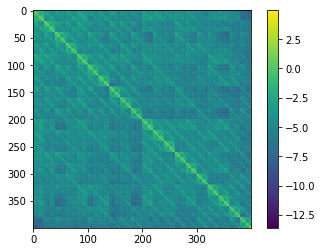

In [69]:
print(tot_hamiltonian)
for i in range(hamiltonian_qq.shape[0]):
    print(i,QPC.quasiparticle_basis[i],'\n')
    
plt.imshow(np.log(np.abs(tot_hamiltonian).todense()+10**-20))
plt.colorbar()

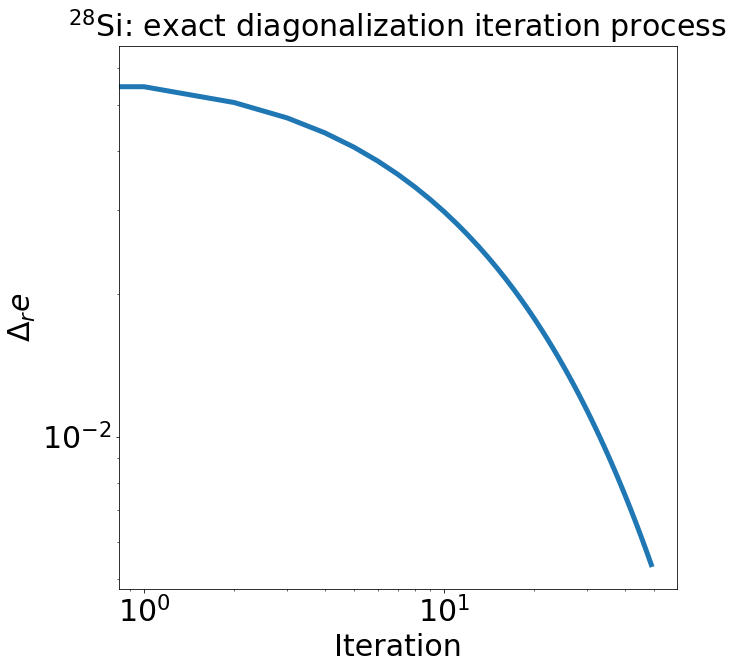

In [70]:
plt.figure(figsize=(10,10))
plt.plot(history_errors_exact,linewidth=5)
plt.xlabel('Iteration',fontsize=30)
plt.ylabel(r'$\Delta_r e$',fontsize=30)
plt.tick_params(labelsize=30)
plt.title(title+': exact diagonalization iteration process',fontsize=30)
plt.loglog()
plt.show()

## Quantum Annealing Algorithm with this perturbation method

#### Initial Hamiltonian in QQ

In [21]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1



print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(NSMHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

e0,psis=InitialHamiltonian.get_spectrum(n_states=1)
psi_configuration=psis[:,0]

initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996


Restrict the Initial Hamiltonian in the Quasiparticle Framework

-15.405709999999997 [ 5.54276816e-17  4.79696282e-17 -2.00000000e+00 -4.09280162e-17
  1.17273759e-16 -9.64789837e-17 -1.03708143e-16  9.80859362e-17
 -1.00629879e-17  1.05020725e-17 -1.04240306e-16  1.30838016e-17
 -1.81318905e-17 -1.00834889e-16 -3.94775476e-17 -9.46046122e-17
 -1.08889864e-16 -1.11706876e-16  1.04073512e-16  1.00471324e-16
 -5.55111512e-17]


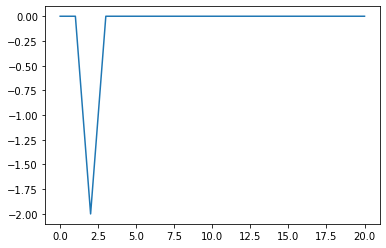

In [22]:
initialhamiltonianQQ=QPC.particles2quasiparticles @ InitialHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T

values,psis=eigsh(initialhamiltonianQQ,k=1)

psi_configuration_qq=QPC.particles2quasiparticles.dot(psi_configuration)

print(values[0],((psis[:,0]-psi_configuration_qq)))
plt.plot(psis[:,0]-psi_configuration_qq)
plt.show()

Perform the Quantum annealing Protocol for the QQ Hamiltonian

In [25]:
from scipy.sparse.linalg import eigsh,expm_multiply

tf=10
nsteps=100
nlevels=10

spectrum=np.zeros((nlevels,nsteps))
energy=np.zeros(nsteps)
fidelity=np.zeros(nsteps)

time=np.linspace(0,tf,nsteps)
dt=time[1]-time[0]
psi=psi_configuration_qq.copy()

egs_qq,psigs=eigsh(hamiltonian_qq,k=1)

egs_qq=egs_qq[0]
psigs=psigs[:,0]

for i,t in enumerate(time):
    
    hamiltonian_t=(1-t/tf)*initialhamiltonianQQ+(t/tf)*hamiltonian_qq
    psi=expm_multiply(-1j*dt*hamiltonian_t,psi)
    
    spectrum[:,i],psis=eigsh(hamiltonian_t,k=nlevels)
    
    energy[i]=psi.conjugate().dot(hamiltonian_t.dot(psi))
    fidelity[i]=(psi.conjugate().dot(psigs)).conjugate()*(psi.conjugate().dot(psigs))

print(fidelity[-1],(energy[-1]-egs_qq)/egs_qq)


def linear_quantum_annealing(psi:np.ndarray,tot_hamiltonian,initialhamiltonianQQ,tf,nsteps,nlevels):
    spectrum=np.zeros((nlevels,nsteps))
    energy=np.zeros(nsteps)
    fidelity=np.zeros(nsteps)

    time=np.linspace(0,tf,nsteps)
    dt=time[1]-time[0]
    psi=psi_configuration_qq.copy()

    egs_qq,psigs=eigsh(tot_hamiltonian,k=1)

    egs_qq=egs_qq[0]
    psigs=psigs[:,0]

    for i,t in enumerate(time):
        
        hamiltonian_t=(1-t/tf)*initialhamiltonianQQ+(t/tf)*tot_hamiltonian
        psi=expm_multiply(-1j*dt*hamiltonian_t,psi)
        
        spectrum[:,i],_=eigsh(hamiltonian_t,k=nlevels)
        
        energy[i]=psi.conjugate().dot(hamiltonian_t.dot(psi))
        fidelity[i]=(psi.conjugate().dot(psigs)).conjugate()*(psi.conjugate().dot(psigs))

    print('VALUES=',fidelity[-1],(energy[-1]-egs_qq)/egs_qq,energy[-1])
    return fidelity,energy,spectrum

0.9994035571210128 -0.00014870200347664276


/tmp/ipykernel_3393933/3088042289.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  energy[i]=psi.conjugate().dot(hamiltonian_t.dot(psi))
/tmp/ipykernel_3393933/3088042289.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  fidelity[i]=(psi.conjugate().dot(psigs)).conjugate()*(psi.conjugate().dot(psigs))


Look at the spectrum

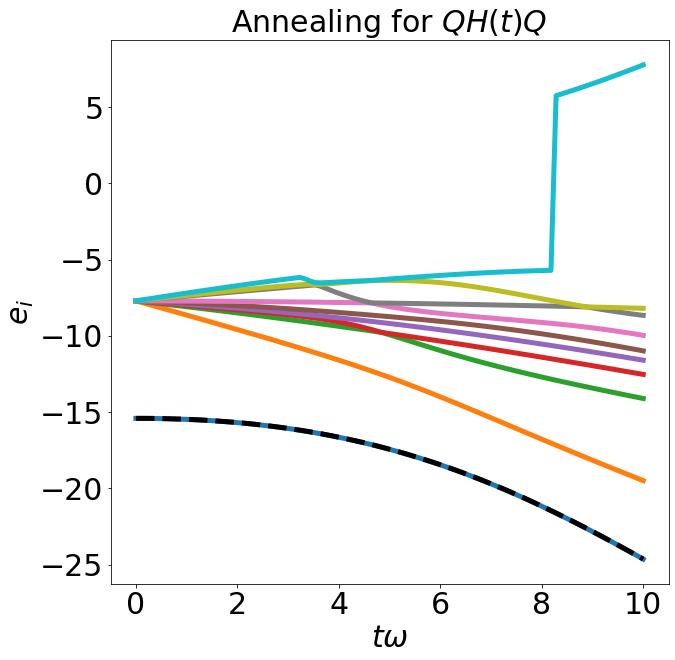

In [26]:
plt.figure(figsize=(10,10))

for i in range(nlevels):
    
    plt.plot(time,spectrum[i],linewidth=5)
plt.plot(time,energy,linestyle='--',color='black',linewidth=5,label=r'$e(t)$')
plt.ylabel(r'$e_i$',fontsize=30)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.title(r'Annealing for $Q H(t) Q$',fontsize=30)
plt.show()

Iterative algorithm for getting the exact energy

Classical Part of the Algroithm (matrix multiplication)

In [278]:
nsteps_iteration=20
single_term = hamiltonian_rq  # Start with initial term
approximations=[]
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result


100%|██████████| 20/20 [00:00<00:00, 1791.75it/s]


In [252]:
approximations=[]
for i in trange(nsteps_iteration):
    single_term=hamiltonian_rq
    for j in range(i):
        single_term= (hamiltonian_rr @ single_term)
    single_term=(hamiltonian_qr @ single_term) 
    approximations.append(single_term)

100%|██████████| 20/20 [00:00<00:00, 885.78it/s]


In [300]:
tf=10
nsteps=100
time=np.linspace(0,tf,nsteps)

fidelities=[]
energies=[]
spectrums=[]

tot_hamiltonian=hamiltonian_qq
fidelity,energy,spectrum=linear_quantum_annealing(psi_configuration_qq,tot_hamiltonian,initialhamiltonianQQ,tf,nsteps,nlevels)

e=energy[-1]

    
energy_history=[]
error_history=[]
fidelity_history=[]
for r in range(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    for j in range(r):
        tot_hamiltonian=tot_hamiltonian+approximations[j]/e**(j+1)
    fidelity,energy,spectrum=linear_quantum_annealing(psi_configuration_qq,tot_hamiltonian,initialhamiltonianQQ,tf,nsteps,nlevels)

    fidelities.append(fidelity)
    energies.append(energy)
    spectrums.append(spectrum)
    e=energy[-1]
    fidelity_history.append(1-fidelity[-1])
    energy_history.append(e)
    error_history.append(np.abs((e-egs[0])/egs[0]))
    print(np.abs((e-egs[0])/egs[0]),'index=',r)
    

/tmp/ipykernel_3128970/2666559387.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  energy[i]=psi.conjugate().dot(hamiltonian_t.dot(psi))
/tmp/ipykernel_3128970/2666559387.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  fidelity[i]=(psi.conjugate().dot(psigs)).conjugate()*(psi.conjugate().dot(psigs))


VALUES= 0.8777812234190315 -0.0031955284898123664 -81.9382980998325
VALUES= 0.877781223419033 -0.003195528489811677 -81.9382980998325
0.1168082053652809 index= 0
VALUES= 0.9231982680485205 -0.002280679340496807 -83.57718054305487
0.0991431139514789 index= 1
VALUES= 0.9520890341528807 -0.0015692396234636486 -84.94063047848151
0.08444683854316028 index= 2
VALUES= 0.9694476540622391 -0.0010824510932955242 -86.05771862227274
0.0724060333841602 index= 3
VALUES= 0.9798611572223154 -0.0007615863709470234 -86.97469228314861
0.0625222106545863 index= 4
VALUES= 0.9862004862476603 -0.000551438022123044 -87.73358494414919
0.05434230227538622 index= 5
VALUES= 0.9901296277659274 -0.0004132998028269112 -88.36757029745996
0.04750873756941125 index= 6
VALUES= 0.9926099909303557 -0.0003219803198301454 -88.90193506474581
0.041748957481792866 index= 7
VALUES= 0.9942064101378655 -0.0002612026691577711 -89.35596654499336
0.036855069188287876 index= 8
VALUES= 0.9952569189926516 -0.00022029722508674457 -89.74

In [ ]:
print(tot_hamiltonian.shape)

Spectrum of the Last plot

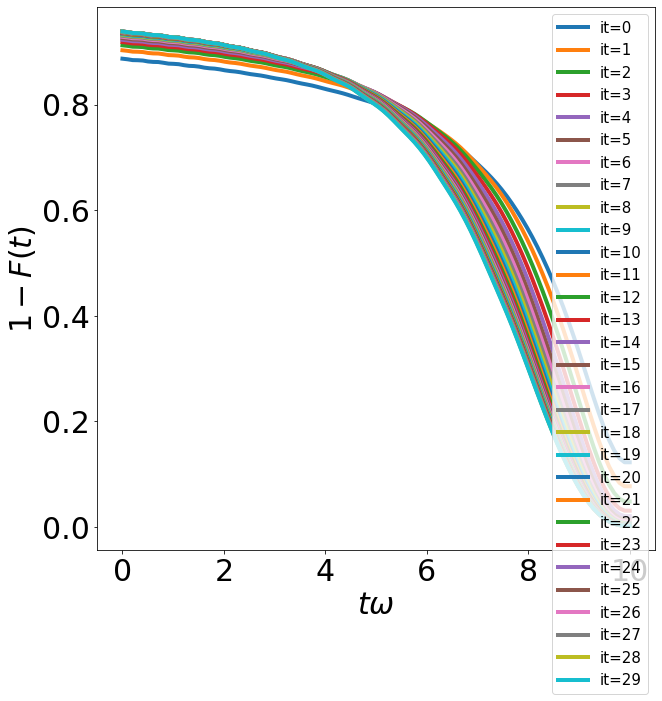

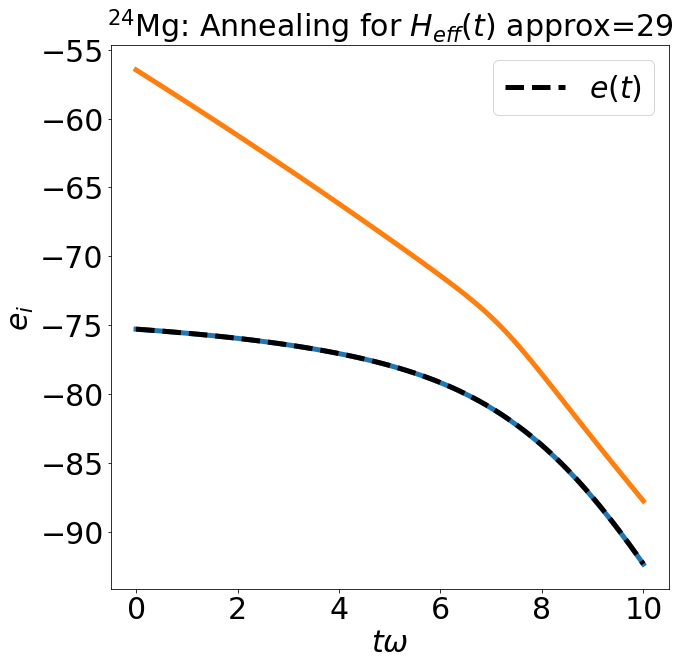

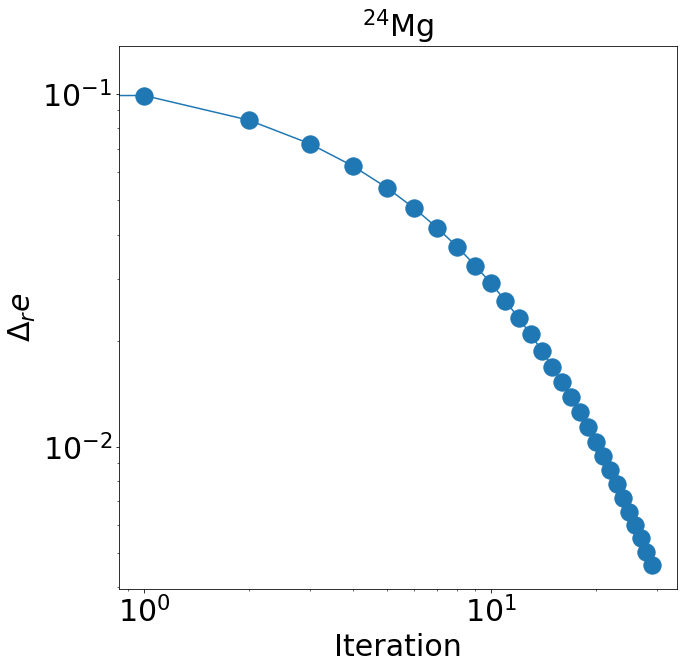

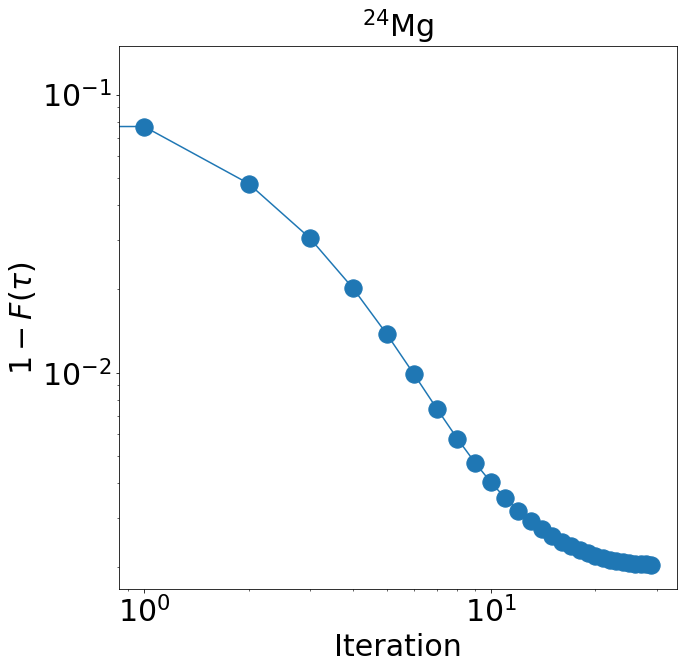

In [301]:
idx_iteration=r

fidelity=fidelities[idx_iteration]
spectrum=spectrums[idx_iteration]
energy=energies[idx_iteration]

plt.figure(figsize=(10,10))

for i in range(nsteps_iteration):
    plt.plot(time,1-fidelities[i],label=f'it={i}',linewidth=4)
plt.legend(fontsize=15)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$1-F(t)$',fontsize=30)
#plt.loglog()
plt.show()

plt.figure(figsize=(10,10))

for i in range(nlevels):
    plt.plot(time,spectrum[i],linewidth=5)
plt.plot(time,energy,linestyle='--',color='black',linewidth=5,label=r'$e(t)$')
plt.ylabel(r'$e_i$',fontsize=30)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.title(title+r': Annealing for $H_{eff}(t)$ approx='+f'{idx_iteration}',fontsize=30)
plt.legend(fontsize=30)
plt.show()


plt.figure(figsize=(10,10))
plt.plot(error_history)
plt.scatter(np.arange(nsteps_iteration),error_history,s=300)
plt.xlabel('Iteration',fontsize=30)
plt.ylabel(r'$\Delta_r e$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30)
plt.title(title,fontsize=30)
plt.loglog()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(fidelity_history)
plt.scatter(np.arange(nsteps_iteration),fidelity_history,s=300)
plt.xlabel('Iteration',fontsize=30)
plt.ylabel(r'$1-F(\tau)$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30)
plt.title(title,fontsize=30)
plt.loglog()
plt.show()

## Quantum Optimal control Algorithm with this perturbation method

#### Imports


In [10]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize,dual_annealing
from tqdm import trange
from src.qml_utils.utils import Schedule,SchedulerModel
from scipy.sparse import csr_matrix, diags
from numpy.linalg import eigh

#### Initial Hamiltonian in QQ

In [11]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1



print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(NSMHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

e0,psis=InitialHamiltonian.get_spectrum(n_states=1)
psi_configuration=psis[:,0]

initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996


Restrict the Initial Hamiltonian in the Quasiparticle Framework

-15.405709999999996 [-3.75143134e-17  1.87991367e-17 -2.00000000e+00 -7.95292993e-17
  8.43039381e-18 -5.42521219e-17  8.01388693e-19  2.82858082e-17
  3.24800844e-18  2.97272648e-17  3.36390606e-17 -3.06121405e-17
 -3.23238788e-18 -5.03741066e-17  1.33033727e-18  8.13837451e-18
 -4.63281792e-17  4.54328160e-17  2.56033035e-17  2.03430444e-17
 -1.38777878e-17]


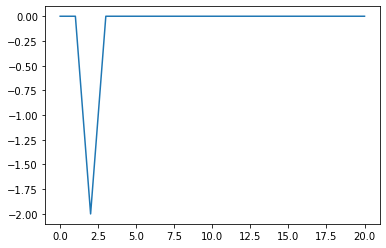

In [12]:
initialhamiltonianQQ=QPC.particles2quasiparticles @ InitialHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T

values,psis=eigsh(initialhamiltonianQQ,k=1)

psi_configuration_qq=QPC.particles2quasiparticles.dot(psi_configuration)

print(values[0],((psis[:,0]-psi_configuration_qq)))
plt.plot(psis[:,0]-psi_configuration_qq)
plt.show()

Perform the Quantum annealing Protocol for the QQ Hamiltonian

In [ ]:
tf=10
nsteps=100

model=SchedulerModel(initial_state=psi_configuration_qq,target_hamiltonian=pairing_hamiltonian_qq,second_target_hamiltonian=meanfiled_hamiltonian_qq,initial_hamiltonian=initialhamiltonianQQ,tf=tf,nsteps=nsteps,number_of_parameters=5,type='F-CRAB',seed=42,reference_hamiltonian=hamiltonian_qq,mode='F-CRAB',random=False,J2operator=None)
print(model.parameters.shape)


bounds=[(0,20) for i in range(model.parameters.shape[0])]

local_search_options = {
    'method': 'L-BFGS-B',  # Specify L-BFGS-B as the local search method
    'bounds': bounds       # Pass the bounds
}

res = minimize(
                    model.forward,
                    model.parameters,
                    method='L-BFGS-B',
                    tol=10**-6,
                    callback=model.callback,
                    options=None,
                    
)

#res=dual_annealing(model.forward,bounds,callback=model.callback,maxiter=1000,maxfun=1000,local_search_options=local_search_options,no_local_search=True)

model.parameters = res.x
energy = model.forward(model.parameters)

print(energy,egs)
print(model.parameters)

(30,)
(-21.056131733191165-1.7763568394002505e-15j)
(-22.53631073818596+0j)
(-22.904014590658278+3.552713678800501e-15j)
(-23.083210117063985+4.440892098500626e-16j)
(-23.422673704765934-1.7763568394002505e-15j)
(-23.688952018066768-1.7763568394002505e-15j)
(-23.892835987333285+2.6645352591003757e-15j)
(-24.105561282145274+0j)
(-24.275284087092476+0j)
(-24.277565211441463+0j)
(-24.278714057649687+4.440892098500626e-16j)
(-24.282696355015254+0j)
(-24.28900940212903+0j)
(-24.297797428309128+4.440892098500626e-16j)
(-24.317416346426484+1.7763568394002505e-15j)
(-24.336726126479817+0j)
(-24.359308774346466-1.7763568394002505e-15j)
(-24.367977909352348-1.7763568394002505e-15j)
(-24.372743094223885+1.7763568394002505e-15j)
(-24.378440592567685-1.7763568394002505e-15j)
(-24.38398555232368+1.7763568394002505e-15j)
(-24.38886352898448+3.552713678800501e-15j)
(-24.389839868291517+0j)
(-24.389951878128272+0j)
(-24.390168467513675-3.552713678800501e-15j)
(-24.390885731843635+1.7763568394002505e-15

In [36]:
e=energy

Classical Part of the Algroithm (matrix multiplication)

In [13]:
nsteps_iteration=20
single_term = hamiltonian_rq  # Start with initial term
approximations=[]
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result


100%|██████████| 20/20 [00:00<00:00, 2810.35it/s]


In [14]:
approximations=[]
for i in trange(nsteps_iteration):
    single_term=hamiltonian_rq
    for j in range(i):
        single_term= (hamiltonian_rr @ single_term)
    single_term=(hamiltonian_qr @ single_term) 
    approximations.append(single_term)

100%|██████████| 20/20 [00:00<00:00, 762.07it/s]


In [ ]:
tf=10
nsteps=100
time=np.linspace(0,tf,nsteps)

fidelities=[]
energies=[]
spectrums=[]

tot_hamiltonian=hamiltonian_qq


    
energy_history=[]
error_history=[]
fidelity_history=[]
for r in range(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    for j in range(r):
        tot_hamiltonian=tot_hamiltonian+approximations[j]/e**(j+1)
    model=SchedulerModel(initial_state=psi_configuration_qq,target_hamiltonian=pairing_hamiltonian_qq,second_target_hamiltonian=0.,mean_field_target_hamiltonain=meanfiled_hamiltonian_qq,initial_hamiltonian=initialhamiltonianQQ,tf=tf,nsteps=nsteps,number_of_parameters=3,type='F-CRAB',seed=42,reference_hamiltonian=tot_hamiltonian,mode='F-CRAB',random=False,J2operator=None)
    print(model.parameters.shape)
    if r!=0:
        print('saved parameters')
        model.parameters=old_parameters

    bounds=[(0,20) for i in range(model.parameters.shape[0])]

    local_search_options = {
        'method': 'L-BFGS-B',  # Specify L-BFGS-B as the local search method
        'bounds': bounds       # Pass the bounds
    }

    res = minimize(
                        model.forward,
                        model.parameters,
                        method='L-BFGS-B',
                        tol=10**-6,
                        callback=model.callback,
                        options=None,
                        
    )


    model.parameters = res.x
    energy = model.forward(model.parameters)
    print(energy,egs)
    print(model.parameters)    
    old_parameters=model.parameters

    energies.append(energy)
    e=energy
    energy_history.append(e)
    error_history.append(np.abs((e-egs[0])/egs[0]))
    print(np.abs((e-egs[0])/egs[0]),'index=',r)
    

(18,)


(-17.880815448881226+3.552713678800501e-15j)
(-23.214256487510106-8.881784197001252e-16j)
(-23.281077399445255+1.7763568394002505e-15j)
(-23.712077293586717+0j)
(-23.805671863197965+1.7763568394002505e-15j)
(-23.84594586808095+0j)
(-23.932923163800027+8.326672684688674e-17j)
(-24.247308404000947+0j)
(-24.308482471094138-5.329070518200751e-15j)
(-24.32142008656559+0j)
(-24.324346030464017+0j)
(-24.333097038628527+0j)
(-24.336943657739294+0j)
(-24.34794696631718-8.881784197001252e-16j)
(-24.350142874440795+1.1102230246251565e-16j)
(-24.35111154972169+8.881784197001252e-16j)
(-24.353129155436122+0j)
(-24.35528443942004+8.881784197001252e-16j)
(-24.35864375863866-1.7763568394002505e-15j)
(-24.361353629321655-3.552713678800501e-15j)
(-24.362809768206557+1.7763568394002505e-15j)
(-24.36426375648516+0j)
(-24.365588190579572+0j)
(-24.369128480876643+3.552713678800501e-15j)
(-24.372753014157226-1.7763568394002505e-15j)
(-24.37650079279434+0j)
(-24.378796087529985+0j)
(-24.37981645212286-1.77635

In [ ]:
print(tot_hamiltonian.shape)

plt.plot(energy_history)
plt.show()

Spectrum of the Last plot

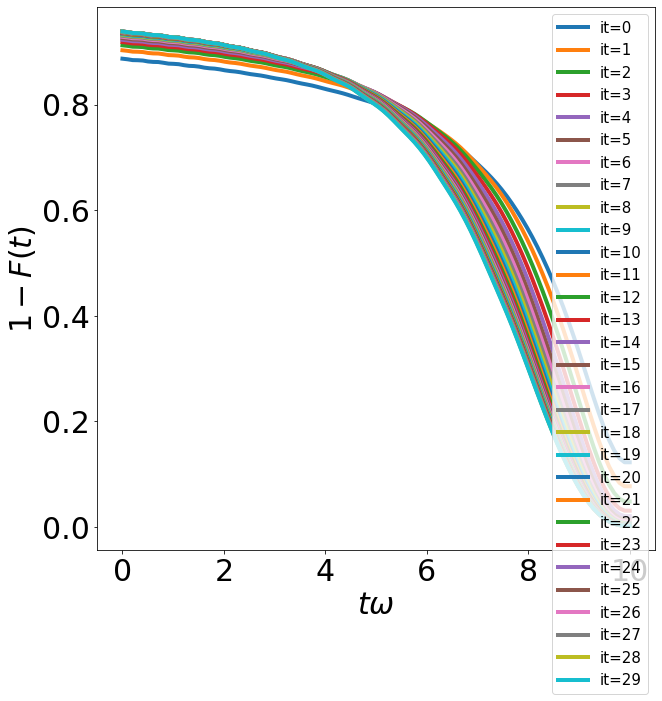

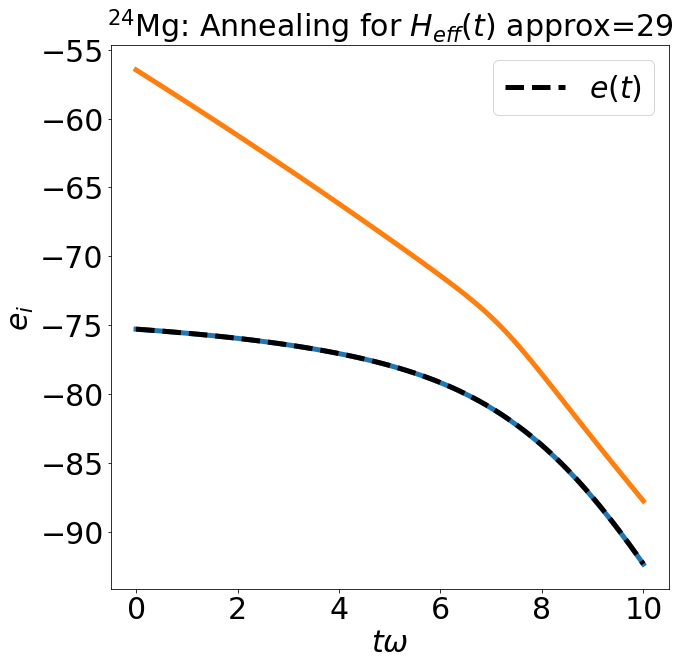

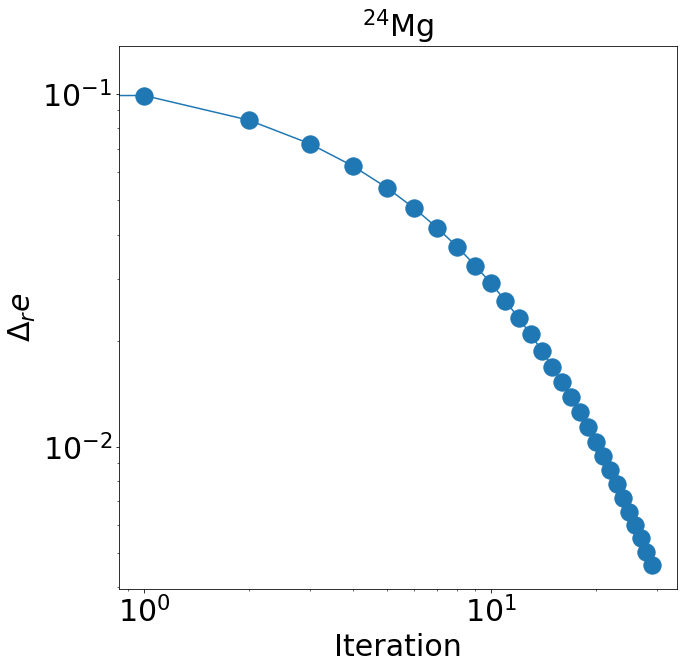

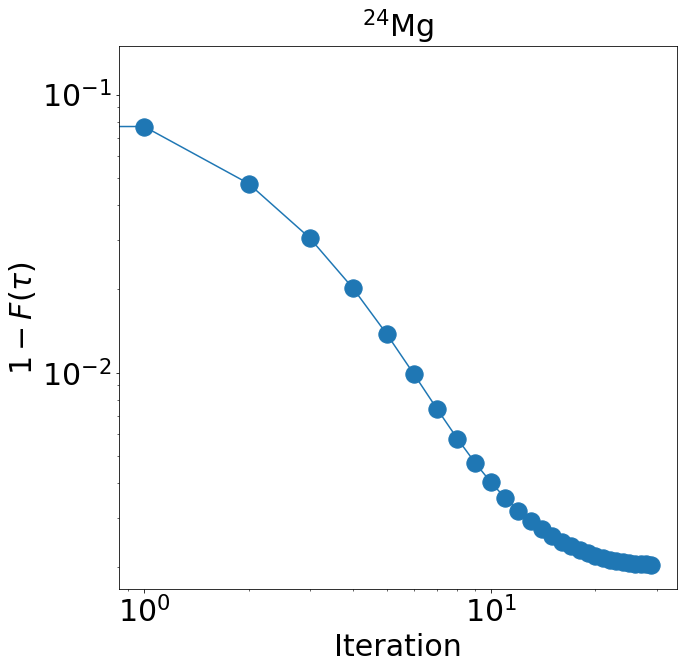

In [ ]:
idx_iteration=r

fidelity=fidelities[idx_iteration]
spectrum=spectrums[idx_iteration]
energy=energies[idx_iteration]

plt.figure(figsize=(10,10))

for i in range(nsteps_iteration):
    plt.plot(time,1-fidelities[i],label=f'it={i}',linewidth=4)
plt.legend(fontsize=15)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$1-F(t)$',fontsize=30)
#plt.loglog()
plt.show()

plt.figure(figsize=(10,10))

for i in range(nlevels):
    plt.plot(time,spectrum[i],linewidth=5)
plt.plot(time,energy,linestyle='--',color='black',linewidth=5,label=r'$e(t)$')
plt.ylabel(r'$e_i$',fontsize=30)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.title(title+r': Annealing for $H_{eff}(t)$ approx='+f'{idx_iteration}',fontsize=30)
plt.legend(fontsize=30)
plt.show()


plt.figure(figsize=(10,10))
plt.plot(error_history)
plt.scatter(np.arange(nsteps_iteration),error_history,s=300)
plt.xlabel('Iteration',fontsize=30)
plt.ylabel(r'$\Delta_r e$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30)
plt.title(title,fontsize=30)
plt.loglog()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(fidelity_history)
plt.scatter(np.arange(nsteps_iteration),fidelity_history,s=300)
plt.xlabel('Iteration',fontsize=30)
plt.ylabel(r'$1-F(\tau)$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30)
plt.title(title,fontsize=30)
plt.loglog()
plt.show()

## Different Effective Hamiltonian

In [57]:
hamiltonian_qq=QPC.particles2quasiparticles @ QQHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ RRHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ RRHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ RRHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


values,psi=eigsh(hamiltonian_qq,k=1)
e0=values[0]

print(values[0])
values,psi=eigsh(hamiltonian_qq+(1/e0)*hamiltonian_qr @ hamiltonian_rq,k=1)

e1=values[0]

values,psi=eigsh(hamiltonian_qq+(1/e1)*hamiltonian_qr @ hamiltonian_rq+(1/e1**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq,k=1)

e2=values[0]
values,psi=eigsh(hamiltonian_qq+(1/e2)*hamiltonian_qr @ hamiltonian_rq+(1/e2**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq+(1/e2**3)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rr @ hamiltonian_rq,k=1)


print(values[0],np.abs((values[0]-egs[0])/egs[0]))

9.080000000000004
18.9035988550334 1.9318477727769614


In [58]:


tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result
    
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    for j in range(i):
        tot_hamiltonian=tot_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(tot_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

100%|██████████| 30/30 [00:00<00:00, 255.83it/s]

9.079999999999995
1.4475961345615347 index= 0
19.932081069626406
1.982546524287657 index= 1
10.40114075017383
1.5127214091198538 index= 2
18.90359885503339
1.9318477727769612 index= 3
11.094228455285018
1.5468869793533222 index= 4
18.171175519658583
1.8957431633302175 index= 5
11.38273184988864
1.5611086758546946 index= 6
18.31075338805337
1.902623616453989 index= 7
11.46157792557491
1.5649953717470424 index= 8
20.373221117208544
2.004292403153082 index= 9
11.23200760229537
1.5536787649948438 index= 10
30.407775843599396
2.498943053767479 index= 11
10.292371238450956
1.5073596455730138 index= 12
125.11827632767717
7.167671458950475 index= 13
9.099892358540684
1.448576722974544 index= 14
1583.1729400202817
79.0420802087554 index= 15
9.08150225632019
1.4476701878789402 index= 16
4272.38119426711
211.6058709171094 index= 17
9.080555902145353
1.4476235376068494 index= 18
11246.476057121927
555.3919835469854 index= 19
9.080211075550832
1.4476065394735012 index= 20
29632.152616478015
1461.70